# Mapping Ensemble Spread and Statistical Significance
## (An Example Using Precipitation)
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Pull Data of Interest: Historical Plus SSP](#data_io)

[Do Gridpoint Significance Testing](#sigtest)

[Map Epoch Differences With Significance Values](#diffmaps)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will practice some techniques for assessing statistical significance of changes in climate data, and ways to represent significance on map plots!

This will allow you to practice skills learned in previous tutorials:
- [Mapping Climate Data](https://github.com/climate-datalab/Map-Plots/blob/main/1.%20Mapping%20Climate%20Data.ipynb) (putting spatial data onto a map using Cartopy)
- [Plotting Regional Time Series Using Shapefiles](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb)  (masking out irregular regions from the climate model grid using shape files)
- [Ensemble Spread and Statistical Significance](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/3.%20Ensemble%20Spread%20and%20Statistical%20Significance.ipynb)  (calculating significance of differences)

while also learning a new skill that will be presented below:
- **Stippling map areas** to show where differences are and are not significant!

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. We'll be using all the same packages as [tutorial 3 in this repo](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/3.%20Ensemble%20Spread%20and%20Statistical%20Significance.ipynb), including Scipy! As we did previously, we'll import the `scipy.stats` sub-package into our environment as `stats`.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

<a id='data_io'></a> 
## **Pull Data of Interest: Historical Plus SSP**

We'll continue working with the CMIP6 data catalog hosted on AWS:

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

Let's continue our approach from tutorial 3, of identifying ensembles of **historical** and **SSP3-7.0** output! As we discussed there, we'll pull data from the ACCESS-CM2 model, since it has a nice moderate ensemble size (5 members) that will let us get a sense for spread while not taking _that_ long to read in the data.

I'll follow the workflow for reading in the data and putting it into an easy-to-use xarray Dataset explained in tutorial 3. Here information for both the historical and future projections is extracted, but ONLY including members that are contained in BOTH projections to make sure we're using comparable sets of data for both time periods. 


**NOTE:** up till now, all the tutorials relied on surface air temperature ("tas") data. Let's try something else! Precipitation is called `pr` in CMIP jargon, and is an atmosphere variable like surface air temperature. We'll stick with monthly data to make the file sizes manageable, which means we'll still be using the `Amon` "table_id"!

In [3]:
# Extract data just for ACCESS-CM2
# Specify search terms to query catalog 
source_id = 'ACCESS-CM2'
table_id = 'Amon'
variable_id = 'pr'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

We can take a quick look at the output data frames `res_access_hist` and `res_access_ssp` to make sure everything looks reasonable:

In [ ]:
# Print the data frames
print(res_access_hist.df)

print(res_access_ssp.df)

Now we repeat the workflow from tutorial 3. First, list the unique ensemble members that exist in each of the historical and SSP ensembles, then find the members which are common between them. For this particular ensemble, the members happen to be identical, but going through this exercise is important since that's often not the case!

In [4]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

Next, we loop over each of the unique member ids, and do the following:

1) Locate the member id in the historical and SSP data frames;

2) Read in the historical and SSP data associated with that member from both data frames;

3) Concatenate the historical/SSP data in time, to get a continuous time series for that member;

4) Add the resulting xarray Dataset to a list of output data.

After the loop is complete, we then use `xr.concat` to make the whole thing into a nice package with a new dimension called `member`, and store the member names as the coordinate information for that dimension.

In [5]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r1i1p1f1


/Users/samstevenson/opt/anaconda3/lib/python3.8/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


r3i1p1f1
r5i1p1f1
r2i1p1f1
r4i1p1f1



#### **Convert units to make the results more intuitive**

Before we get into the more sophisticated calculations, let's take a minute to think about the _units_ of the data. You can display them either by printing out the entire `pr` variable and scrolling down to view the units, or by using this syntax:

In [6]:
# Print out units of precip data
access_data.pr.units

'kg m-2 s-1'

These are standard units for precipitation, but are the total _mass flux_ of water and not something that people intuitively understand like mm or inches.

Instead, let's convert this to a more intuitive unit: mm/day! The conversion factor for this is:

mm/day = kg/(m^2 s) x (1 m^3/1000 kg) x (1000 mm/1 m) x (86400 s/day)

where the 1000 kg/m^3 is the density of water, and the seconds/day number comes from multiplying 24 hours x 60 minutes/hour x 60 seconds/minute.

In [7]:
# Convert kg/(m^2 s) to mm/day
access_data['pr'] = access_data['pr'] * 86400

<a id='sigtest'></a> 
## **Do Gridpoint Significance Testing**

Now, we are NOT going to perform the regional averaging steps we used in tutorial 3! We're asking a different question here:

_How significant are changes in average precipitation between two time periods, for every place on Earth?_

First, we need to define time periods of interest, over which to do our differencing. Let's choose the early period to be 1850-1900, and the late period to be 2050-2100; you can change this to whatever you want!

In [8]:
# Get data for an earlier period: 20th century
data_early = access_data.sel(time=slice("1850-01-01", "1900-12-31"))

# Get data for a later period: 21st century
data_late = access_data.sel(time=slice("2050-01-01", "2100-12-31"))

Because we're interested in finding the difference in the _time-averaged_ precipitation between the two periods, we then take the mean over the time dimension for both epochs:

In [10]:
# Take the time average
data_early_mn = data_early.mean(dim="time")
data_late_mn = data_late.mean(dim="time")

Now comes the slow part! You don't have to do it this way, but I find it more efficient to extract the data from both periods into Numpy arrays, so that we can quickly iterate over each lat and lon point to apply our statistical test.

**Depending on your machine, this may take 3-5 minutes or more; be patient!**

In [14]:
# Extract the values into Numpy arrays
pr_early = data_early_mn.pr.values
pr_late = data_late_mn.pr.values

The good news is that once you've done the extraction, the rest should go quite quickly!  

We can loop through each combination of latitude and longitude, then calculate the significance of differences between our two samples at every point. This will come in handy in a couple minutes when we make our plots of epoch differences!

The code block below does a couple of things:

1) Defines empty output Numpy arrays, of size [lat x lon] where the lat and lon dimensions are the same as the input precipitation data array;

2) Loops over lat/lon points, and extracts the p value associated with the statistical test of interest (here I'm doing BOTH the T-test AND the rank-sum test as a demonstration, but usually you'll only want to do one or the other); and

3) Saves the output p value in the output array!

In [24]:
# Define empty output arrays
# T-test
pr_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
# Rank-sum test
pr_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.lat)):
    for lonidx in range(len(data_early_mn.lon)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        
        # Save results in the output array
        pr_pvals_rs[latidx, lonidx] = pval_rs
        pr_pvals_t[latidx, lonidx] = ttest.pvalue

<a id='diffmaps'></a> 
## **Map Epoch Differences With Significance Values**

OK now we're ready to display some results! Let's make a global map showing the epoch differences in precipitation between the late and early periods, following the same steps as we used back in the [mapping tutorial](https://github.com/climate-datalab/Map-Plots/tree/main) section. 

To make things run faster, we can use the Numpy versions of the data rather than xarray!

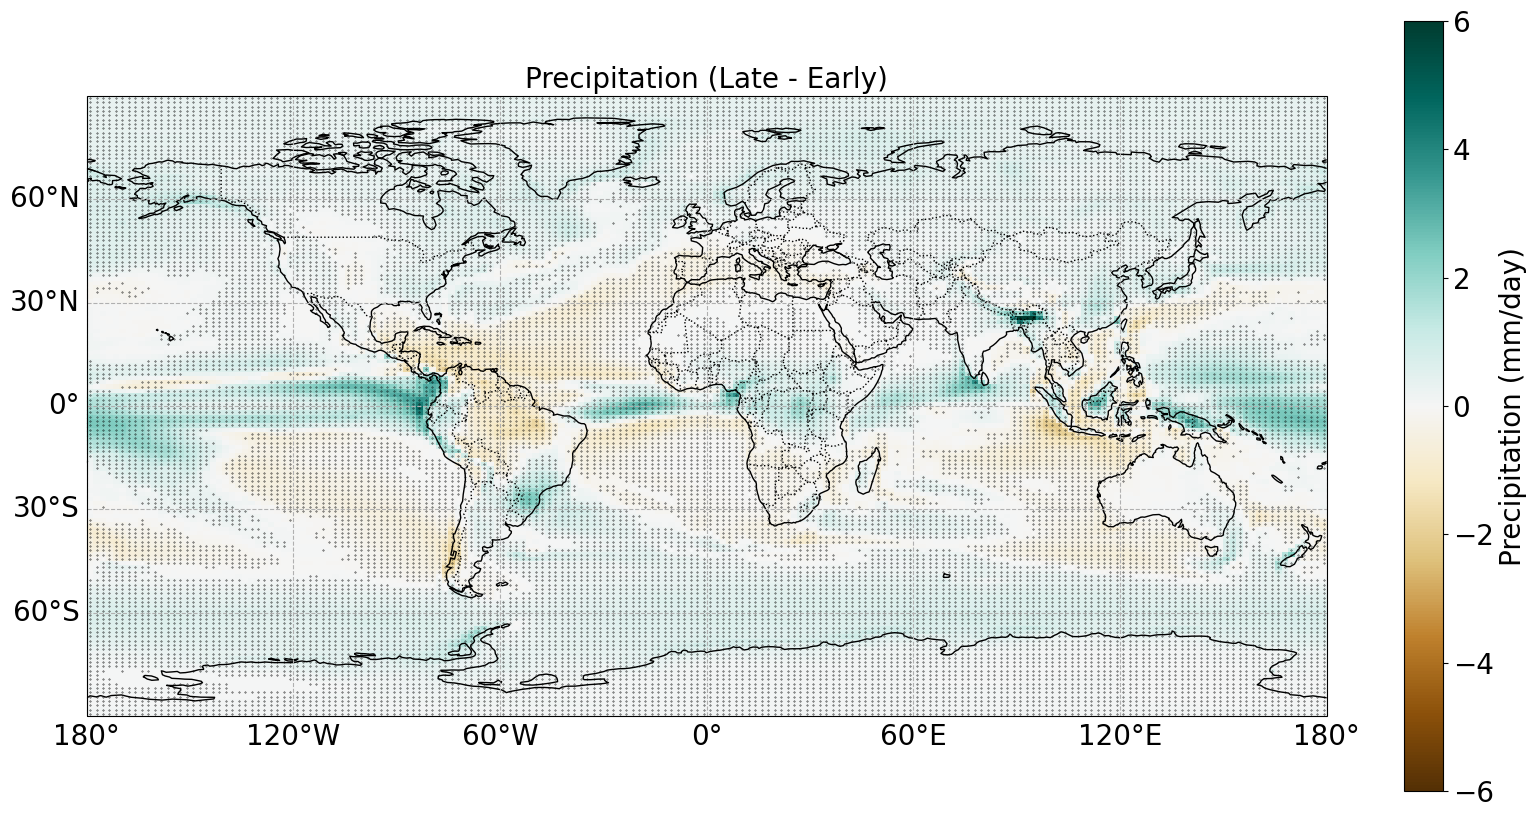

In [39]:
# Calculate ensemble-mean epoch difference
ensmn_prdiff = pr_late.mean(axis=0) - pr_early.mean(axis=0)

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_prdiff, 
                     transform=map, cmap="BrBG", vmin=-6, vmax=6)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation (mm/day)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(pr_pvals_rs < 0.05)
lats = data_early_mn.coords['lat'][latitudes].values
lons = data_early_mn.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Precipitation (Late - Early)", fontsize= 20)
plt.show()

In [34]:
pr_pvals_rs

array([[0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344],
       [0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344],
       [0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344],
       ...,
       [0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344],
       [0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344],
       [0.00902344, 0.00902344, 0.00902344, ..., 0.00902344, 0.00902344,
        0.00902344]])